## Importing libraries and files

In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
#from prettytable import PrettyTable

ann_arr = load_model('RP_Arrival_time/Arrival_ANN4')
ann_end = load_model('RP_End_time/End_ANN4')
ann_chg = load_model('RP_Change_time/Change_ANN1')

#Section1
ann1 = load_model('RP_Section_1_new3/Section1_new3_ANN_2')
sc1 = pickle.load(open('RP_Section_1_new3/Section1_new3_scaler_ANN_2.pkl', 'rb'))
#Section2
ann2 = load_model('RP_Section_2_new2/Section2_new_ANN_2')
sc2 = pickle.load(open('RP_Section_2_new/Section2_new_scaler_ANN_2.pkl', 'rb'))
#Section3
ann3 = load_model('RP_Section_3_new/Section3_new_ANN_2')
sc3 = pickle.load(open('RP_Section_3_new/Section3_new_scaler_ANN_2.pkl', 'rb'))
#Section4
ann4 = load_model('RP_Section_4_new/Section4_new_ANN_7')
sc4 = pickle.load(open('RP_Section_4_new/Section4_new_scaler_ANN_7.pkl', 'rb'))
#Section5
ann5 = load_model('RP_Section_5_new/Section5_new_ANN_4')
sc5 = pickle.load(open('RP_Section_5_new/Section5_new_scaler_ANN_4.pkl', 'rb'))
#Section6
ann6 = load_model('RP_Section_6_new/Section6_new_ANN_2')
sc6 = pickle.load(open('RP_Section_6_new/Section6_new_scaler_ANN_2.pkl', 'rb'))

## Input details

In [3]:
Mass = 15.8
Standoff_distance = 2.2
Angle = 0
start_time = 0
#termination_time = 110
interval = 0.01
Time_adj = 0
Pressure_adj = 101.25

## Pressure Profile

In [4]:
arr = np.array ([[Mass,Standoff_distance, Angle]])

arrival_time = ann_arr.predict(arr)
end_time = ann_end.predict(arr)
change_time = ann_chg.predict(arr)
termination_time = end_time+50
print ("arrival", arrival_time, "end", end_time, "change", change_time)

def stable_state(start, end, interval):    
    t = np.arange(start, end + interval, interval)
    t = t.reshape(len(t),1)

    p = np.repeat(0, len(t)).reshape(len(t),1)
    
    values = np.concatenate ((t, p), axis = 1)
    return values

def p_fluctuation(standoff_distance, d_set):
    if 1.5 <= standoff_distance <= 3:
        d_set[:,0:4] = sc1.transform(d_set[:,0:4])
        p_f = ann1.predict(d_set)
        section = 1
        
    elif 3 < standoff_distance <= 7:
        d_set[:,0:4] = sc2.transform(d_set[:,0:4])
        p_f = ann2.predict(d_set)
        section = 2
        
    elif 7 < standoff_distance <= 13:
        d_set[:,0:4] = sc3.transform(d_set[:,0:4])
        p_f = ann3.predict(d_set)
        section = 3
        
    elif 13 < standoff_distance <= 19:
        d_set[:,0:4] = sc4.transform(d_set[:,0:4])
        p_f = ann4.predict(d_set)
        section = 4
        
    elif 19 < standoff_distance <= 25:
        d_set[:,0:4] = sc5.transform(d_set[:,0:4])
        p_f = ann5.predict(d_set)
        section = 5
        
    elif 25 < standoff_distance <= 30:
        d_set[:,0:4] = sc6.transform(d_set[:,0:4])
        p_f = ann6.predict(d_set)
        section = 6
        
    else:
        print ("Out of trained range")
    return p_f, section

if termination_time < arrival_time:
    start = start_time
    end = termination_time
    values1 = stable_state(start, end, interval)
    arrival_time = 0
    end_time = 0

else:
    start = start_time
    end = arrival_time
    values1 = stable_state(start, end, interval)
    
    if termination_time < end_time:
        end_time = termination_time
        
    else:
        start = end_time
        end = termination_time
        values3 = stable_state(start, end, interval)

t2= np.arange(arrival_time, end_time + interval, interval)
t2 = t2.reshape(len(t2),1)

if t2[0] < change_time:
    ph2 = np.array([[0, 1]])
else:
    ph2 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative= np.array([1, 0])

for time in t2[1:]:
    if time < change_time:
        ph2=np.vstack((ph2,positive))
    else:
        ph2=np.vstack((ph2,negative))
        
m2 = np.repeat(Mass, len(t2)).reshape(len(t2),1)
d2 = np.repeat(Standoff_distance, len(t2)).reshape(len(t2),1)
a2 = np.repeat(Angle, len(t2)).reshape(len(t2),1)
d_set = np.concatenate ((m2, d2, a2, t2, ph2), axis = 1)

#p2 = p_fluctuation(Standoff_distance, d_set)
p2, section = p_fluctuation(Standoff_distance, d_set)
p2 = p2.reshape((-1, 1))
values2 = np.concatenate ((t2, p2), axis = 1)


if 'values2' in globals():
    ml_model = np.concatenate((values1, values2), axis=0)
    if 'values3' in globals():
        ml_model = np.concatenate((ml_model, values3), axis=0)
else:
    ml_model = values1
    
X1 = ml_model[:,0]
y1_int = ml_model[:,1]
y1 = y1_int + 101.25
print (section)
print(min(y1))

1/1 [==============================] - 0s 176ms/step
arrival [[1.0994965]] end [[17.015318]] change [[2.809203]]


C:\Users\z5379606\AppData\Local\Temp\ipykernel_3052\1768846974.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = np.arange(start, end + interval, interval)
C:\Users\z5379606\AppData\Local\Temp\ipykernel_3052\1768846974.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2= np.arange(arrival_time, end_time + interval, interval)


50/50 [==============================] - 0s 4ms/step
1
23.602333068847656


In [ ]:
file_path = Path(f'G:/Chamodi/LSDYNA3D/RP_TH_models/RP_Comparison_with_Numerical/{Standoff_distance}m{Mass}kg/{Angle}')
lsdyna = pd.read_csv(file_path, delimiter="\s+", skiprows = 8, skipfooter = 1, header = None, names = ["Time", "Pressure"])

X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']

X2_original=(X2_original*1000)+ Time_adj
y2_original=(y2_original/1000)

# Find the indices for the two values closest to value1 and value2
index1 = (np.abs(X2_original - start_time)).argmin()
index2 = (np.abs(X2_original - termination_time)).argmin()

# Extract the ranges from X2 and y2 based on the indices
X2_original = X2_original[index1:index2+1]
y2_original = y2_original[index1:index2+1]

X2_original = X2_original.to_numpy()
y2_original = y2_original.to_numpy()

print("Numerical length",len(y2_original), "ANN-based length", len(y1))

In [ ]:
X2 = X2_original
y2 = y2_original

In [ ]:
file_path = Path(f'G:/Chamodi/LSDYNA3D/RP_TH_models/RP_Comparison_with_Numerical/{Standoff_distance}m{Mass}kg/{Angle}.xlsx')
lsdyna = pd.read_excel(file_path, names = ["Time", "Pressure"])

X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']

X2_original=(X2_original*1000)+ Time_adj
y2_original=(y2_original/1000)+Pressure_adj

# Find the indices for the two values closest to value1 and value2
index1 = (np.abs(X2_original - start_time)).argmin()
index2 = (np.abs(X2_original - termination_time)).argmin()

# Extract the ranges from X2 and y2 based on the indices
X2_original = X2_original[index1:index2+1]
y2_original = y2_original[index1:index2+1]

X2 = X2_original.to_numpy()
y2 = y2_original.to_numpy()
print(min(y2))
y2_int = y2 - 101.25
print("Numerical length",len(y2_original), "ANN-based length", len(y1))

In [ ]:
file_path = Path(f'G:/Chamodi/LSDYNA3D/RP_TH_models/RP_Comparison_with_Numerical/{Standoff_distance}m{Mass}kg/{Angle}')
lsdyna = pd.read_csv(file_path, delimiter="\s+", skiprows = 8, skipfooter = 1, header = None, names = ["Time", "Pressure"])

X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']

X2_original=((X2_original*1000)+ Time_adj).to_numpy()
y2_original=(y2_original/1000).to_numpy()

In [7]:
file_path = Path(f'G:/Chamodi/LSDYNA3D/RP_TH_models/RP_Comparison_with_Numerical/{Standoff_distance}m{Mass}kg/{Angle}.xlsx')
lsdyna = pd.read_excel(file_path, names = ["Time", "Pressure"])

X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']

X2_original=(X2_original*1000).to_numpy()
y2_original=((y2_original/1000)+Pressure_adj).to_numpy()
X2 = X2_original
y2 = y2_original

[ 52 354]


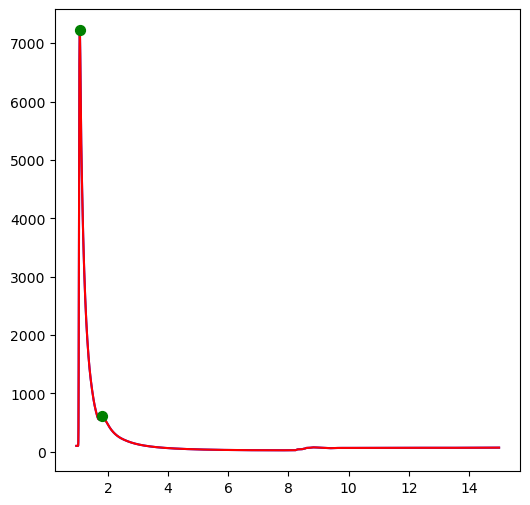

In [12]:
from scipy.signal import find_peaks

# Identify peaks with tolerance parameters
height_threshold = 102.5  # Minimum height of peaks to detect
prominence = 0.01  # Minimum prominence of peaks in pressure units
width = 5  # Minimum width of peaks in time units

# Find peaks
peaks, properties = find_peaks(y2_original, height=height_threshold, prominence=prominence, width=width)
print (peaks)

# Ensure there are at least two peaks
if len(peaks) >= 1:
    #first_peak_index = peaks[0]

    # Create a copy of pressure data to modify
    smoothed_pressure = np.copy(y2_original)

    # Define a window around each peak after the first peak to apply smoothing
    window_radius_r = 80
    window_radius_l = 50 # Adjust the window radius as needed
    selected_peaks = [peaks[1]]

    for peak_index in selected_peaks:
        start = max(peak_index - window_radius_l, 0)
        end = min(peak_index + window_radius_r + 1, len(y2_original))

        # Extract values just outside the window
        if start > 0 and end < len(y2_original):
            start_value = y2_original[start - 1]
            end_value = y2_original[end]
        elif start > 0:
            start_value = y2_original[start - 1]
            end_value = start_value
        elif end < len(y2_original):
            end_value = y2_original[end]
            start_value = end_value
        else:
            start_value = end_value = np.mean(y2_original)  # Fallback in case there are no valid points

        # Create a linearly spaced array between start_value and end_value
        interpolated_values = np.linspace(start_value, end_value, end - start)

        # Apply the interpolated values to the points within the window
        smoothed_pressure[start:end] = interpolated_values
        
y2 = smoothed_pressure
X2 = X2_original
y2_int = y2 - 101.25

plt.figure(figsize=(6,6))
plt.plot(X2_original,y2_original, color = 'blue',label = 'Numerical')
plt.plot(X2, y2, color = 'red',label = 'Numerical')
# Mark the peaks on the plot
plt.scatter(X2_original[peaks], y2_original[peaks], color='green', s=50, label='Peaks', zorder=5)
plt.show()

In [ ]:
plt.rcdefaults()

Integrated Area Under the Curve: 1234.1150333329947, 412.6165599299195


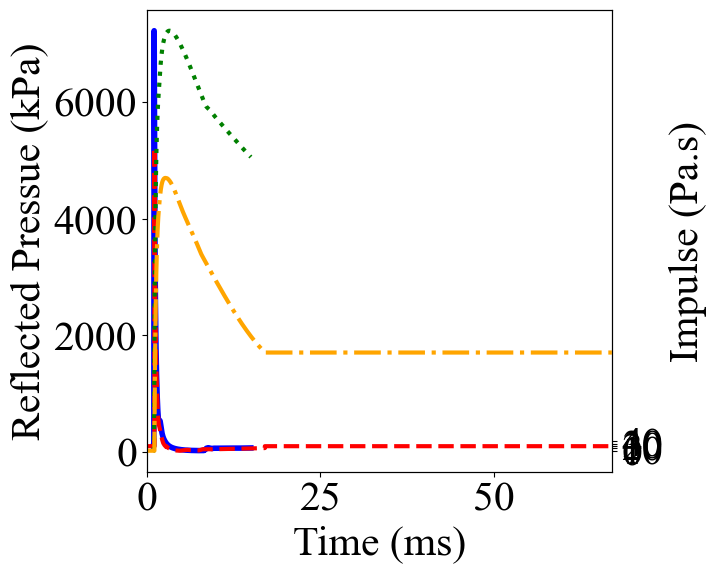

In [14]:
# Perform numerical integration using the trapezoidal rule
area_num = np.trapz(y2_int, X2)
area_ann = np.trapz(y1_int, X1)
print(f"Integrated Area Under the Curve: {area_num}, {area_ann}")

# Perform cumulative integration using the trapezoidal rule
ci_num = np.cumsum(np.gradient(X2) * y2_int)
ci_ann = np.cumsum(np.gradient(X1) * y1_int)

# Create the plot
fig, ax1 = plt.subplots(figsize=(6, 6))
plt.rcParams["font.family"] = "Times New Roman"

# Plot the original data (y vs time) on the primary y-axis
ax1.plot(X2, y2, color = 'blue',label = 'Numerical - Pressure', linewidth=4)
ax1.plot(X1, y1, linestyle = 'dashed', color = 'red', label = 'ANN framework - Pressure', linewidth=3)
ax1.set_xlabel('Time (ms)', fontsize = 30)
ax1.set_ylabel('Reflected Pressue (kPa)', fontsize = 30)
ax1.tick_params(axis='both', labelsize = 30)
#ax1.set_xticks([60,70,80,90,100,110])
#ax1.set_yticks([100,105,110,115,120,125])
#ax1.set_xlim(start_time,termination_time)
ax1.set_xlim(start_time,termination_time)
#ax1.legend(loc='upper center', bbox_to_anchor=(0.4, -0.2), fontsize=30, ncol=1, frameon = False)

# Create a secondary y-axis for the cumulative integration
ax2 = ax1.twinx()
ax2.plot(X2, ci_num, color='green', linestyle='dotted',label='Numerical - Impulse', linewidth=3)
ax2.plot(X1, ci_ann, linestyle='dashdot', label='ANN framework - Impulse', color='orange', linewidth=3)
ax2.set_ylabel('Impulse (Pa.s)', fontsize = 30)
#ax2.set_yticks([0,10,20,30,40])
ax2.tick_params(axis='both', labelsize = 30)
#ax2.legend(loc='upper center', bbox_to_anchor=(0.3, -0.45), fontsize=30, ncol=1, frameon = False)

#plt.savefig(f'RP_Num&ANN_Comparison/Section{section}_{Standoff_distance}m{Mass}kg/{Angle}deg_new2.png', dpi=150, bbox_inches='tight')
plt.show()

15.00074 15.00074


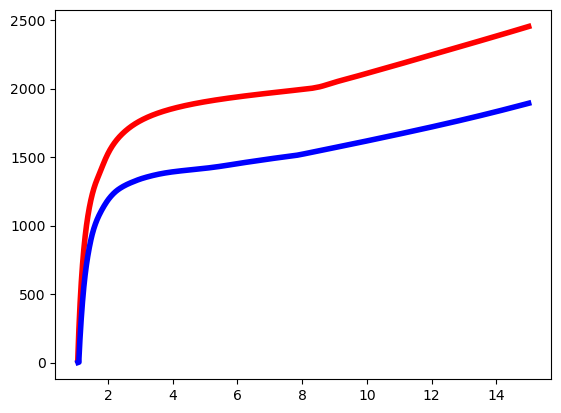

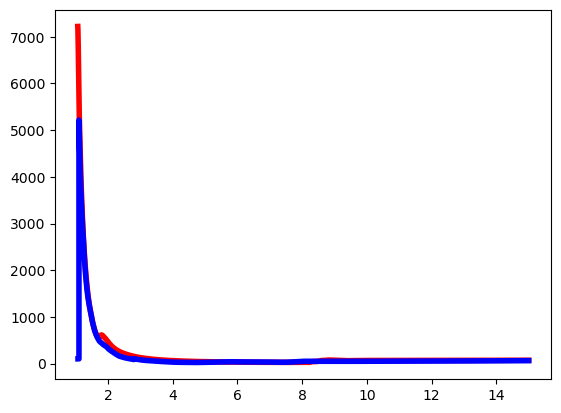

22.60765566840015
ann_auc= 1891.5879540919414
num_auc= 2444.1538377324905


In [8]:
def boundary_search(X,y):
    start_time = None
    end_time_bs = None
    start_index = np.argmax(y)
    start_time = X[start_index]
    zero_index1 = next((i for i, val in enumerate(y[start_index:], start=0) if val <= 101.25), None)
    if isinstance (zero_index1, int):
       zero_index1 = zero_index1 + start_index
       min_index = np.argmin(y[zero_index1:])+zero_index1
       zero_index2 = next((i for i, val in enumerate(y[min_index:], start=0) if val < 101.25), None)
       if isinstance (zero_index2, int):
           end_index = zero_index2 + min_index
           end_time_bs = X[end_index]
       else:
           end_time_bs = X[-1]
    else:
        print('zero_index1 error')
    return start_time, end_time_bs

start_time_num, end_time_num = boundary_search(X2,y2)

start_time_ann = float(arrival_time[0][0])
end_time_ann = float(end_time[0][0])
start_time_overall = min(start_time_num, start_time_ann)
end_time_overall = max(end_time_num, end_time_ann)
end_time_overall = min(end_time_overall, X2[-1])
print (end_time_overall, X2[-1])
def auc_cal(X,y, start_time, end_time):
    dataset = pd.DataFrame(X, columns=['Time'])
    dataset['Pressure'] = y
    filtered_data = dataset[(dataset['Time'] >= start_time) & (dataset['Time'] <= end_time)]
    # Extract time and pressure values
    time_values = filtered_data['Time'].values
    pressure_values = filtered_data['Pressure'].values
    
    # Integrate using the trapezoidal rule
    integration_result = np.trapz(pressure_values, time_values)
    auc_series = np.cumsum(np.gradient(time_values) * pressure_values)
    
    return integration_result, auc_series, time_values, pressure_values

ann_auc, ann_auc_series, ann_time, ann_pressure = auc_cal(X1,y1, start_time_overall, end_time_overall)
num_auc, num_auc_series, num_time, num_pressure = auc_cal(X2,y2, start_time_overall, end_time_overall)

fig_auc = plt.plot(figsize=(6, 6))

plt.plot(num_time, num_auc_series, color = 'red',label = 'Numerical', linewidth=4)
plt.plot(ann_time, ann_auc_series, color = 'blue',label = 'ANN', linewidth=4)
plt.show()

fig_auc2 = plt.plot(figsize=(6, 6))

plt.plot(num_time, num_pressure, color = 'red',label = 'Numerical', linewidth=4)
plt.plot(ann_time, ann_pressure, color = 'blue',label = 'ANN', linewidth=4)
plt.show()

error = (abs(ann_auc-num_auc)/num_auc)*100
print(error)
print ('ann_auc=',ann_auc)
print ('num_auc=',num_auc)

In [ ]:
# Numerical
max_index_num = np.argmax(y2)

zero_crossing_index = next((i for i, val in enumerate(y2[max_index_num:], start=0) if val <= 101.25), None)

if isinstance (zero_crossing_index, int):
    zero_crossing_index = zero_crossing_index+max_index_num
    change_time_num = X2[zero_crossing_index]
    positive_duration_num = change_time_num - X2[max_index_num]
    min_index_num = np.argmin(y2[zero_crossing_index:])+zero_crossing_index
    negative_peak_pressure_num = y2[min_index_num]
    negative_peak_time_num = X2[min_index_num]
    
    zero_crossing_index2 = next((i for i, val in enumerate(y2[min_index_num:], start=0) if val >= 101.25), None)
    
    if isinstance((zero_crossing_index2, zero_crossing_index) , int):
        zero_crossing_index2 = zero_crossing_index2+min_index_num
        end_time_num = X2[zero_crossing_index2]
        negative_duration_num = end_time_num - change_time_num
    else:
        negative_duration_num = max(X2)-change_time_num
else:
    positive_duration_num = None

if 'negative_peak_pressure_num' not in globals():
    negative_peak_pressure_num = None
if 'negative_peak_time_num' not in globals():
    negative_peak_time_num = None

positive_peak_pressure_num = y2[max_index_num]
positive_peak_time_num = X2[max_index_num]


# ANN-based
positive_duration_ann = float(change_time - arrival_time)
negative_duration_ann = float(end_time - change_time)

max_index_ann = np.argmax(y1)

a_zero_crossing_index = next((i for i, val in enumerate(y1[max_index_ann:], start=0) if val <= 101.25), None)

if isinstance (a_zero_crossing_index, int):
    a_zero_crossing_index = a_zero_crossing_index+max_index_ann
    min_index_ann = np.argmin(y1[a_zero_crossing_index:])+a_zero_crossing_index
    negative_peak_pressure_ann = y1[min_index_ann]
    negative_peak_time_ann = X1[min_index_ann]

if 'negative_peak_pressure_ann' not in globals():
    negative_peak_pressure_ann = None
if 'negative_peak_time_ann' not in globals():
    negative_peak_time_ann = None

positive_peak_pressure_ann = y1[max_index_ann]
positive_peak_time_ann = X1[max_index_ann]

def per_diff(value1, value2):
    per_dif = (abs(value1-value2)/value1)*100
    return per_dif

print('positive peak pressure- n', positive_peak_pressure_num, 'a', positive_peak_pressure_ann,'%', per_diff(positive_peak_pressure_num,positive_peak_pressure_ann))
print('negative peak pressure- n', negative_peak_pressure_num, 'a', negative_peak_pressure_ann,'%', per_diff(negative_peak_pressure_num,negative_peak_pressure_ann))
print('positive peak time- n', positive_peak_time_num, 'a', positive_peak_time_ann, '%', per_diff(positive_peak_time_num, positive_peak_time_ann))
print('negative peak time-n', negative_peak_time_num, 'a', negative_peak_time_ann, '%', per_diff(negative_peak_time_num, negative_peak_time_ann))
print('positive duration-n', positive_duration_num, 'a', positive_duration_ann, '%', per_diff(positive_duration_num, positive_duration_ann))
print('negative duration-n', negative_duration_num, 'a', negative_duration_ann, '%', per_diff(negative_duration_num, negative_duration_ann))
print('peak impulse-n', max(ci_num), 'a', max(ci_ann), '%', per_diff(max(ci_num), max(ci_ann)))